<a href="https://colab.research.google.com/github/AI-Cultural-Heritage-Lab/ushmm_model_comparisons/blob/main/Generate_and_Compare_LLM_Outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [7]:
#import API keys and mount google drive
from google.colab import drive
from google.colab import userdata
!pip install --upgrade openai
#make sure we have openAI and Gemini access tokens before proceeding (key icon on left)
import os
from openai import OpenAI
import google.generativeai as genai
# Pass the API key to Open AI
os.environ['OPEN_AI_API_KEY'] = userdata.get("OPEN_AI_PROJECT_KEY")
client = OpenAI(api_key=os.environ.get("OPEN_AI_API_KEY"))
# Pass the API key to Gemini
os.environ['GEMINI_API_KEY'] = userdata.get("GEMINI_PROJECT_KEY")
# Pass the API key to Grok
os.environ['GROK_API_KEY'] = userdata.get("GROK_PROJECT_KEY")
# Pass the API key to SERP
os.environ['SERP_API_KEY'] = userdata.get("SERP_PROJECT_KEY")
#mount drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
## Import Data - imports the data as an excel file from the Google Sheet containing the text you want to feed to the LLM(s)

import gdown
import pandas as pd


#ALL 6000 search queries (1000 for each country - USA, Germany, S Korea, Russia, Turkey, China)
#this is Ulysses' "ushmm_data_with_articles" spreadsheet that includes the ushmmm article link and text for each query
url_ALL = 'https://docs.google.com/spreadsheets/d/1i6PRehieuZKl2Zk7EoJFjwRuS4e-NR8mtBAbTt6rZ4c/edit?gid=525940975#gid=525940975'
export_url_ALL= f"{url_ALL}"+"/export?format=xlsx"
temp_file_ALL = "file_ALL.xlsx"
gdown.download(export_url_ALL, temp_file_ALL, quiet=False, fuzzy=True)

# Load the Excel file into pandas
df_ALL = pd.read_excel(temp_file_ALL)

# Display the DataFrame
print(df_ALL.head())

ModuleNotFoundError: No module named 'gdown'

In [8]:
import pandas as pd
#If that does not work, simply load the excel file from the directory
df_ALL = pd.read_excel('ushmm_data_with_articles.xlsx')
# Display the DataFrame
print(df_ALL.head())

   id                                          file_name  file_row_index  \
0   0  Copy of Holocaust Encyclopedia - search querie...               0   
1   1  Copy of Holocaust Encyclopedia - search querie...               1   
2   2  Copy of Holocaust Encyclopedia - search querie...               2   
3   3  Copy of Holocaust Encyclopedia - search querie...               3   
4   4  Copy of Holocaust Encyclopedia - search querie...               4   

        location  year                            Top queries  Clicks  \
0  United States  2024  how many people died in the holocaust   40678   
1  United States  2024                      armenian genocide   37535   
2  United States  2024                 holocaust encyclopedia   35664   
3  United States  2024                    first they came for   34702   
4  United States  2024                              holocaust   33996   

   Impressions     CTR  Position ai_overview_standalone  \
0       189593  0.2146      1.02             

# Initialize LLMs and define functions to query them

In [10]:
#load API keys
OPENAI_API_KEY = userdata.get('OPEN_AI_PROJECT_KEY')
GOOGLE_API_KEY = userdata.get('GEMINI_PROJECT_KEY')
GROK_API_KEY = userdata.get('GROK_PROJECT_KEY')

In [11]:
#GPT

from typing import List, Dict, Any, Callable
from pydantic import BaseModel, Field, ValidationError
import json
import time

# Import Colab Secrets userdata module
from google.colab import userdata
import os
from openai import OpenAI


# Pass the API key to Open AI
client = OpenAI(api_key=userdata.get('OPEN_AI_PROJECT_KEY'))

def query_gpt4o(prompt: str) -> str:
  try:
    time.sleep(0.13)
    response = client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model="gpt-4o",
    )
    return response.choices[0].message.content
  except Exception as e:
    return f"GPT-4o Error: {str(e)}"

  #alternative querying functions
def base_gpt(input, model):
    response = client.chat.completions.create(
        messages=[
            {"role": "user", "content": input,}],
        model=model,
    )
    output_dict = {
        "model": model,
        "output": response.choices[0].message.content
    }
    return response.choices[0].message.content

def generate_LLM_response(row) -> List[str]:
    #Let's start the the fewest assumptions
    input_data = row['Top queries']
    response = base_gpt(input_data, "gpt-4o")
    return response

In [12]:
#Gemini

from typing import List, Dict
import json
import os
import requests
import google.generativeai as genai
from google.colab import userdata
from openai import OpenAI

# Initialize Gemini
genai.configure(api_key=GOOGLE_API_KEY)

# Query Gemini 2.0 Flash
def query_gemini(prompt: str) -> str:
    model = genai.GenerativeModel(
    'gemini-2.0-flash',
    generation_config=genai.GenerationConfig(
        max_output_tokens=2000,
        temperature=0.9,
    ))
    try:
        time.sleep(4.1)  # ~4 seconds delay to stay under 2.0 flash rate limit 15 requests/minute
        response = model.generate_content(prompt)
        return response.text.strip()
    except Exception as e:
        return f"Error: {str(e)}"

In [13]:
#Grok

# Query Grok latest version
# Initialize Grok Client
grok_client = OpenAI(
    api_key=GROK_API_KEY,
    base_url="https://api.x.ai/v1",
)

# Function to Query Grok
def query_grok(prompt: str) -> str:
    try:
        time.sleep(0.13) # ~1/8 seconds delay to stay under grok-2-1212 rate limit of 8 requests/second
        response = grok_client.chat.completions.create(
            model="grok-2-latest",  # Use the latest Grok model
            messages=[{"role": "user", "content": prompt}],
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Grok API Error: {str(e)}"

#Generate LLM Responses

In [14]:
# Generate LLM Responses=
def generate_LLM_responses(row) -> Dict[str, str]:
    prompt = row['Top queries']

    return {
        "GPT-4o": query_gpt4o(prompt),
        "Gemini": query_gemini(prompt),
        "Grok": query_grok(prompt)
    }

import pandas as pd

# Process DataFrame and Add LLM Responses
def generate_LLM_responses_df(df):
    # Apply the function to each row and create new columns
    df[['GPT-4o Response', 'Gemini Response', 'Grok Response']] = df['Top queries'].apply(
        lambda prompt: pd.Series(generate_LLM_responses({"Top queries": prompt}))
    )
    return df


In [14]:
us_search_responses_df = generate_LLM_responses_df(df_ALL[:1000])
print(us_search_responses_df.head())

NameError: name 'generate_LLM_responses_df' is not defined

# Import Cleaned Data set (optional)

In [19]:
#If we want to specifically run the comparison tests on a different data set of queries and responses (such as outputs that have already been generated), import it here
# e.g. Cleaned data set of 776 US Queries with no Non-English or otherwise erroneous responses
#Load the cleaned file from the directory
df_clean = pd.read_excel('CLEANED US Queries with LLM Responses (No Composite Scores).xlsx')
# Display the DataFrame
print(df_clean.head())
us_search_responses_df = df_clean

        location                            Top queries  \
0  United States  how many people died in the holocaust   
1  United States                      armenian genocide   
2  United States                 holocaust encyclopedia   
3  United States                    first they came for   
4  United States                              holocaust   

                                       ushmm_article  \
0  #How Many People did the Nazis Murder? | Holoc...   
1  #The Armenian Genocide (1915-16): Overview | H...   
2  #Introduction to the Holocaust: What was the H...   
3  #Martin Niemöller: "First they came for the So...   
4  #Introduction to the Holocaust: What was the H...   

                                     GPT-4o Response  \
0  Approximately six million Jews were killed dur...   
1  The Armenian Genocide was a systematic mass ex...   
2  The Holocaust Encyclopedia is a comprehensive ...   
3  The phrase "First they came for..." is the beg...   
4  The Holocaust was the sys

# Define functions for obtaining similarity and readability metrics

READABILITY METRICS

In [20]:
#Word Count
import re
def word_count(text):
    #Returns the number of words in a given text using regex
    words = re.findall(r'\b\w+\b', text)
    return len(words)

#Flesch Reading Score
def count_sentences(text):
    """Counts the number of sentences based on punctuation."""
    return max(1, len(re.findall(r'[.!?]', text)))  # Avoid zero sentences

def count_words(text):
    """Counts the number of words in the text."""
    return max(1, len(text.split()))  # Avoid division by zero

def count_syllables(word):
    """Counts the number of syllables in a word using regex heuristics."""
    word = word.lower()
    syllables = re.findall(r'[aeiouy]+', word)  # Matches vowel clusters
    if word.endswith(("es", "ed")) and len(syllables) > 1:
        syllables.pop()  # Discount silent syllables
    return max(1, len(syllables))

def count_total_syllables(text):
    """Counts the total number of syllables in the text."""
    words = re.findall(r'\b\w+\b', text)  # Extract words
    return sum(count_syllables(word) for word in words)

def flesch_reading_ease(text):
    """Calculates the Flesch Reading Ease Score."""
    words = count_words(text)
    sentences = count_sentences(text)
    syllables = count_total_syllables(text)

    asl = words / sentences  # Average Sentence Length
    asw = syllables / words  # Average Syllables per Word

    score = 206.835 - (1.015 * asl) - (84.6 * asw)
    return round(score, 2)

#Coleman Liau Index
def count_letters(text):
    """Counts the number of letters (A-Z, a-z) in the text."""
    return sum(c.isalpha() for c in text)

def count_sentences(text):
    """Counts the number of sentences based on punctuation."""
    return max(1, len(re.findall(r'[.!?]', text)))  # Avoid zero sentences

def coleman_liau_index(text):
    """Calculates the Coleman-Liau Index for readability assessment."""
    letters = count_letters(text)
    words = count_words(text)
    sentences = count_sentences(text)

    L = (letters / words) * 100  # Average letters per 100 words
    S = (sentences / words) * 100  # Average sentences per 100 words

    CLI = 0.0588 * L - 0.296 * S - 15.8
    return round(CLI, 2)

SIMILARITY METRICS

In [22]:
#Cosine Similarity

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# Define Get Embedding Function
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = text, model=model).data[0].embedding

# Example Usage

# Create A text string
text = "Hello, I am a member of a Digital Humanities Lab"

# Apply the function to the text and inspect the output
print(get_embedding(text))

def cosine_similarity_text(text1, text2):
    # Generate Embeeddings for the text
    embedding1 = get_embedding(text1)
    embedding2 = get_embedding(text2)

    # Convert embeddings to numpy arrays
    embedding1 = np.array(embedding1).reshape(1, -1)
    embedding2 = np.array(embedding2).reshape(1, -1)

    # Calculate cosine similarity
    similarity = cosine_similarity(embedding1, embedding2)[0][0]

    # Display the result
    print(f"Cosine similarity: {similarity}")

def cosine_similarity_text_2(text1, text2):
    #Calculate cosine similarity between two long text strings using TF-IDF
    vectorizer = TfidfVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    return cosine_similarity(vectors)[0, 1]

NameError: name 'client' is not defined

In [17]:
#Jaccard Index

from nltk.util import ngrams

def jaccard_index(text1, text2, n=3):
    """Calculate Jaccard index using n-grams for better comparison of longer texts."""
    set1 = set(ngrams(text1.split(), n))
    set2 = set(ngrams(text2.split(), n))

    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))

    return intersection / union if union != 0 else 0

# Apply readability/similarity functions to obtain composite similarity scores

In [18]:
#This function calculates the individual metrics (cosine similarity, jaccard index, flesch score, coleman-liau) individually
def process_text_comparisons(df):

    # Ensure required columns exist
    required_columns = ["ushmm_article", "GPT-4o Response", "Gemini Response", "Grok Response"]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"CSV must contain the columns: {required_columns}")

    # Compute Readability and Word Count
    for col in required_columns:
        df[f"{col} - Word Count"] = df[col].apply(count_words)
        df[f"{col} - Flesch Score"] = df[col].apply(flesch_reading_ease)
        df[f"{col} - Coleman-Liau"] = df[col].apply(coleman_liau_index)

    # Pairwise Comparisons
    pairings = [
        ("ushmm_article", "GPT-4o Response"),
        ("ushmm_article", "Gemini Response"),
        ("ushmm_article", "Grok Response"),
        ("GPT-4o Response", "Gemini Response"),
        ("GPT-4o Response", "Grok Response"),
        ("Gemini Response", "Grok Response"),
    ]

    for col1, col2 in pairings:
        df[f"{col1}/{col2} - Cosine Sim"] = df.apply(lambda row: cosine_similarity_text_2(row[col1], row[col2]), axis=1)
        df[f"{col1}/{col2} - Jaccard Index"] = df.apply(lambda row: jaccard_index(row[col1], row[col2]), axis=1)

    return df

#calculates word count only
def process_word_count(df):

    # Ensure required columns exist
    required_columns = ["ushmm_article", "GPT-4o Response", "Gemini Response", "Grok Response"]
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"CSV must contain the columns: {required_columns}")

    # Compute Readability and Word Count
    for col in required_columns:
        df[f"{col} - Word Count"] = df[col].apply(count_words)
        df[f"{col} - Flesch Score"] = df[col].apply(flesch_reading_ease)
        df[f"{col} - Coleman-Liau"] = df[col].apply(coleman_liau_index)
    return df

#Function for computing the composite similarity between two texts

#Takes in four input similarity metrics
# 1. cosine similarity between two texts
# 2. jaccard index between two texts
# 3. difference in flesch reading score between two texts
# 4. differences in coleman-liau score between two texts
# each of the values are normalized to a [0, 1] scale in which 0 is least similar and 1 is identical
# the values are combined into a weighted average score based on the weights assigned in the constant variables below
COSINE_SIMILARITY_WEIGHT = 0.4
JACCARD_INDEX_WEIGHT = 0.3
FLESCH_SCORE_WEIGHT = 0.15
COLEMAN_LIAU_WEIGHT = 0.15
def composite_similarity(text1, text2):
    cos = cosine_similarity_text_2(text1, text2)
    jac = jaccard_index(text1, text2)
    flesch_sim = 1 - max(0, 1 - abs(flesch_reading_ease(text1) - flesch_reading_ease(text2)) / 100)
    cli_sim = 1 - abs(coleman_liau_index(text1) - coleman_liau_index(text2)) / 20
    return round(COSINE_SIMILARITY_WEIGHT * cos + JACCARD_INDEX_WEIGHT * jac + FLESCH_SCORE_WEIGHT * flesch_sim + COLEMAN_LIAU_WEIGHT * cli_sim, 4)

#Function for taking in a df of USHMM, GPT, Gemini, and Grok responses to queries  and computing the composite similarities between each responses for each query
def compute_composite_similarity_scores(df):
    """
    Prepares a DataFrame by selecting specific columns, adding empty columns for similarity scores,
    and computing similarity between specified pairs of text fields.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A new DataFrame with similarity columns populated.
    """
    import pandas as pd

    # Define the columns to keep
    columns_to_keep = [
        'location', 'Top queries', 'ushmm_article',
        'GPT-4o Response', 'Gemini Response', 'Grok Response'
    ]

    # Define the new empty columns to add
    new_columns = [
        'USHMM-GPT Similarity', 'USHMM-Gemini Similarity', 'USHMM-Grok Similarity',
        'GPT-Gemini Similarity', 'GPT-Grok Similarity', 'Gemini-Grok Similarity',
        'Notes'
    ]

    # Filter the DataFrame to keep only the required columns
    df_new = df[columns_to_keep].copy()

    # Add the new empty columns
    for col in new_columns:
        df_new[col] = ""

    # Define the text column pairs for which similarity is computed
    pairs = [
        ("ushmm_article", "GPT-4o Response", "USHMM-GPT Similarity"),
        ("ushmm_article", "Gemini Response", "USHMM-Gemini Similarity"),
        ("ushmm_article", "Grok Response", "USHMM-Grok Similarity"),
        ("GPT-4o Response", "Gemini Response", "GPT-Gemini Similarity"),
        ("GPT-4o Response", "Grok Response", "GPT-Grok Similarity"),
        ("Gemini Response", "Grok Response", "Gemini-Grok Similarity")
    ]

    # Compute the similarity for each specified pair
    for col1, col2, new_col in pairs:
        df_new[new_col] = df_new.apply(
            lambda row: composite_similarity(row[col1], row[col2]),
            axis=1
        )

    return df_new

In [13]:
us_search_responses_df_with_composite = compute_composite_similarity_scores(us_search_responses_df)

NameError: name 'us_search_responses_df' is not defined

In [66]:
print(us_search_responses_df_with_composite.head())

        location                            Top queries  \
0  United States  how many people died in the holocaust   
1  United States                      armenian genocide   
2  United States                 holocaust encyclopedia   
3  United States                    first they came for   
4  United States                              holocaust   

                                       ushmm_article  \
0  #How Many People did the Nazis Murder? | Holoc...   
1  #The Armenian Genocide (1915-16): Overview | H...   
2  #Introduction to the Holocaust: What was the H...   
3  #Martin Niemöller: "First they came for the So...   
4  #Introduction to the Holocaust: What was the H...   

                                     GPT-4o Response  \
0  Approximately six million Jews were killed dur...   
1  The Armenian Genocide was a systematic mass ex...   
2  The Holocaust Encyclopedia is a comprehensive ...   
3  The phrase "First they came for..." is the beg...   
4  The Holocaust was the sys

# Run t-tests on composite similarity scores

## Run t-tests

In [67]:
import pandas as pd
from scipy.stats import ttest_ind
import itertools
from IPython.display import display

def run_pairwise_t_tests(df):
    similarity_cols = [
        "USHMM-GPT Similarity",
        "USHMM-Gemini Similarity",
        "USHMM-Grok Similarity",
        "GPT-Gemini Similarity",
        "GPT-Grok Similarity",
        "Gemini-Grok Similarity"
    ]

    t_test_results = []

    # Perform pairwise t-tests between all combinations of similarity scores
    for col1, col2 in itertools.combinations(similarity_cols, 2):
        scores1 = df[col1].dropna()
        scores2 = df[col2].dropna()

        if len(scores1) > 1 and len(scores2) > 1:
            t_stat, p_val = ttest_ind(scores1, scores2, equal_var=False)
            t_test_results.append({
                "Comparison": f"{col1} vs {col2}",
                "Mean 1": scores1.mean(),
                "Mean 2": scores2.mean(),
                "t-statistic": round(t_stat, 4),
                "p-value": round(p_val, 4),
                "Significant (p < 0.05)": p_val < 0.05
            })
        else:
            t_test_results.append({
                "Comparison": f"{col1} vs {col2}",
                "Mean 1": scores1.mean() if len(scores1) > 0 else None,
                "Mean 2": scores2.mean() if len(scores2) > 0 else None,
                "t-statistic": None,
                "p-value": None,
                "Significant (p < 0.05)": None
            })

    results_df = pd.DataFrame(t_test_results)
    display(results_df)
    return results_df

In [68]:
results_df = run_pairwise_t_tests(us_search_responses_df_with_composite)

,Comparison,Mean 1,Mean 2,t-statistic,p-value,Significant (p < 0.05)
0,USHMM-GPT Similarity vs USHMM-Gemini Similarity,0.461435,0.436781,6.4519,0.0000,True
1,USHMM-GPT Similarity vs USHMM-Grok Similarity,0.461435,0.462896,-0.4198,0.6747,False
2,USHMM-GPT Similarity vs GPT-Gemini Similarity,0.461435,0.463124,-0.4439,0.6572,False
3,USHMM-GPT Similarity vs GPT-Grok Similarity,0.461435,0.496946,-10.4070,0.0000,True
4,USHMM-GPT Similarity vs Gemini-Grok Similarity,0.461435,0.466882,-1.4164,0.1569,False
5,USHMM-Gemini Similarity vs USHMM-Grok Similarity,0.436781,0.462896,-6.5041,0.0000,True
6,USHMM-Gemini Similarity vs GPT-Gemini Similarity,0.436781,0.463124,-6.1271,0.0000,True
7,USHMM-Gemini Similarity vs GPT-Grok Similarity,0.436781,0.496946,-15.2060,0.0000,True
8,USHMM-Gemini Similarity vs Gemini-Grok Similarity,0.436781,0.466882,-6.9416,0.0000,True
9,USHMM-Grok Similarity vs GPT-Gemini Similarity,0.462896,0.463124,-0.0570,0.9546,False


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   location                      1000 non-null   object 
 1   Top queries                   1000 non-null   object 
 2   ushmm_article                 1000 non-null   object 
 3   GPT-4o Response               1000 non-null   object 
 4   Gemini Response               1000 non-null   object 
 5   Grok Response                 1000 non-null   object 
 6   comments                      2 non-null      object 
 7   USHMM-GPT Similarity          999 non-null    float64
 8   USHMM-Gemini Similarity       999 non-null    float64
 9   USHMM-Grok Similarity         999 non-null    float64
 10  GPT-Gemini Similarity         999 non-null    float64
 11  GPT-Grok Similarity           999 non-null    float64
 12  Gemini-Grok Similarity        999 non-null    f

,location,Top queries,ushmm_article,GPT-4o Response,Gemini Response,Grok Response,comments,USHMM-GPT Similarity,USHMM-Gemini Similarity,USHMM-Grok Similarity,GPT-Gemini Similarity,GPT-Grok Similarity,Gemini-Grok Similarity,Notes,ushmm_article - Word Count,GPT-4o Response - Word Count,Gemini Response - Word Count,Grok Response - Word Count
0,United States,how many people died in the holocaust,#How Many People did the Nazis Murder? | Holoc...,Approximately six million Jews were killed dur...,Historians estimate that the Nazis murdered ap...,The Holocaust was a period of systematic perse...,NaN,0.5835,0.3042,0.4905,0.3407,0.5017,0.3887,NaN,1507.0,72.0,13.0,57.0
1,United States,armenian genocide,#The Armenian Genocide (1915-16): Overview | H...,The Armenian Genocide was a systematic mass ex...,The Armenian Genocide was the systematic destr...,The Armenian Genocide was the systematic exter...,NaN,0.5849,0.6209,0.5882,0.6329,0.6452,0.6493,NaN,616.0,208.0,364.0,232.0
2,United States,holocaust encyclopedia,#Introduction to the Holocaust: What was the H...,The Holocaust Encyclopedia is a comprehensive ...,The Holocaust Encyclopedia is a comprehensive ...,The Holocaust Encyclopedia is a comprehensive ...,NaN,0.5454,0.5471,0.5921,0.6130,0.5764,0.5599,NaN,4400.0,261.0,217.0,359.0
3,United States,first they came for,"#Martin Niemöller: ""First they came for the So...","The phrase ""First they came for..."" is the beg...","""First they came for the socialists, and I did...","""First they came ..."" is the beginning of a fa...",NaN,0.5304,0.3480,0.4940,0.5672,0.6557,0.6318,NaN,1501.0,184.0,70.0,153.0
4,United States,holocaust,#Introduction to the Holocaust: What was the H...,"The Holocaust was the systematic, state-sponso...","The Holocaust was the systematic, state-sponso...","Der Holocaust war eine systematische, staatlic...",NaN,0.5327,0.5116,0.2291,0.4951,0.2859,0.2284,NaN,4400.0,128.0,33.0,156.0



Similarity Scores Summary Statistics:
       USHMM-GPT Similarity  USHMM-Gemini Similarity  USHMM-Grok Similarity  \
count            999.000000               999.000000             999.000000   
mean               0.481896                 0.463325               0.454605   
std                0.222733                 0.210801               0.208786   
min               -2.124700                -2.029100              -1.232500   
25%                0.483200                 0.427700               0.378450   
50%                0.544600                 0.526800               0.531800   
75%                0.586350                 0.579200               0.589050   
max                0.645500                 0.656200               0.652700   

       GPT-Gemini Similarity  GPT-Grok Similarity  Gemini-Grok Similarity  
count             999.000000           999.000000              999.000000  
mean                0.530785             0.520763                0.494519  
std                 0

,USHMM-GPT Similarity,USHMM-Gemini Similarity,USHMM-Grok Similarity,GPT-Gemini Similarity,GPT-Grok Similarity,Gemini-Grok Similarity
0,0.5835,0.3042,0.4905,0.3407,0.5017,0.3887
1,0.5849,0.6209,0.5882,0.6329,0.6452,0.6493
2,0.5454,0.5471,0.5921,0.6130,0.5764,0.5599
3,0.5304,0.3480,0.4940,0.5672,0.6557,0.6318
4,0.5327,0.5116,0.2291,0.4951,0.2859,0.2284


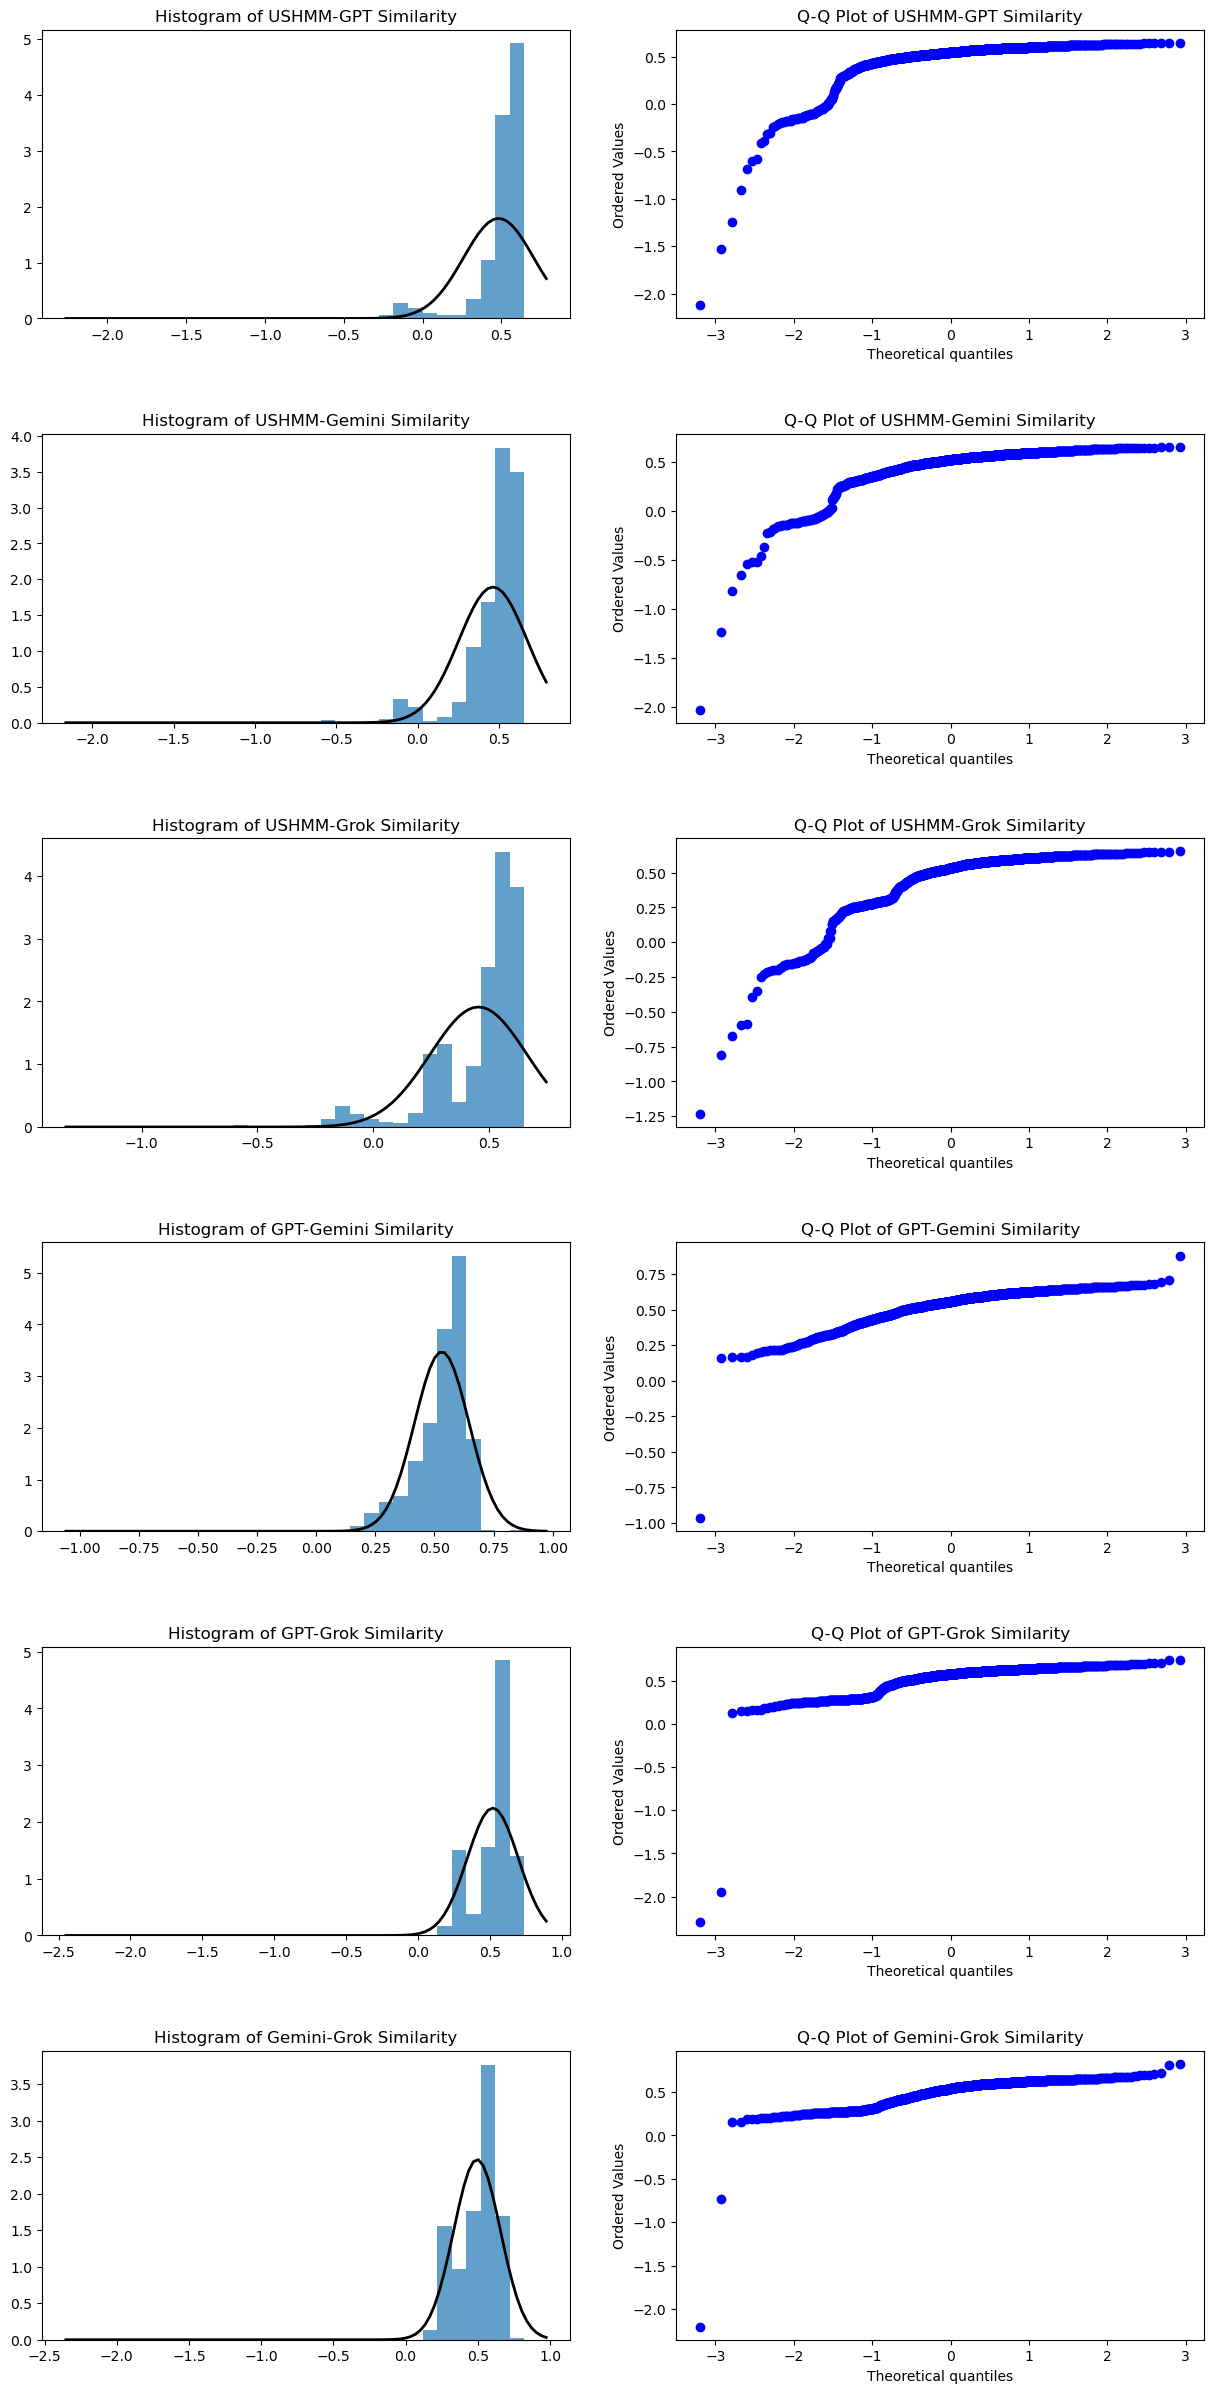


Shapiro-Wilk Test Results:
H0: Data is normally distributed
H1: Data is not normally distributed

Results for each similarity score:

USHMM-GPT Similarity:
Statistic: nan
p-value: 1.0000
Normal distribution? Yes

Cohen's d Effect Sizes:
Interpretation guidelines:
d = 0.2: Small effect
d = 0.5: Medium effect
d = 0.8: Large effect



,Comparison,Cohen's d,Effect Size
0,USHMM-GPT Similarity vs USHMM-Gemini Similarity,0.085641,Negligible
1,USHMM-GPT Similarity vs USHMM-Grok Similarity,0.126424,Negligible
2,USHMM-GPT Similarity vs GPT-Gemini Similarity,-0.275863,Small
3,USHMM-GPT Similarity vs GPT-Grok Similarity,-0.192904,Negligible
4,USHMM-GPT Similarity vs Gemini-Grok Similarity,-0.064858,Negligible
5,USHMM-Gemini Similarity vs USHMM-Grok Similarity,0.041565,Negligible
6,USHMM-Gemini Similarity vs GPT-Gemini Similarity,-0.397370,Small
7,USHMM-Gemini Similarity vs GPT-Grok Similarity,-0.294617,Small
8,USHMM-Gemini Similarity vs Gemini-Grok Similarity,-0.166056,Negligible
9,USHMM-Grok Similarity vs GPT-Gemini Similarity,-0.452064,Small



USHMM-Gemini Similarity:
Statistic: nan
p-value: 1.0000
Normal distribution? Yes

Cohen's d Effect Sizes:
Interpretation guidelines:
d = 0.2: Small effect
d = 0.5: Medium effect
d = 0.8: Large effect



,Comparison,Cohen's d,Effect Size
0,USHMM-GPT Similarity vs USHMM-Gemini Similarity,0.085641,Negligible
1,USHMM-GPT Similarity vs USHMM-Grok Similarity,0.126424,Negligible
2,USHMM-GPT Similarity vs GPT-Gemini Similarity,-0.275863,Small
3,USHMM-GPT Similarity vs GPT-Grok Similarity,-0.192904,Negligible
4,USHMM-GPT Similarity vs Gemini-Grok Similarity,-0.064858,Negligible
5,USHMM-Gemini Similarity vs USHMM-Grok Similarity,0.041565,Negligible
6,USHMM-Gemini Similarity vs GPT-Gemini Similarity,-0.397370,Small
7,USHMM-Gemini Similarity vs GPT-Grok Similarity,-0.294617,Small
8,USHMM-Gemini Similarity vs Gemini-Grok Similarity,-0.166056,Negligible
9,USHMM-Grok Similarity vs GPT-Gemini Similarity,-0.452064,Small



USHMM-Grok Similarity:
Statistic: nan
p-value: 1.0000
Normal distribution? Yes

Cohen's d Effect Sizes:
Interpretation guidelines:
d = 0.2: Small effect
d = 0.5: Medium effect
d = 0.8: Large effect



,Comparison,Cohen's d,Effect Size
0,USHMM-GPT Similarity vs USHMM-Gemini Similarity,0.085641,Negligible
1,USHMM-GPT Similarity vs USHMM-Grok Similarity,0.126424,Negligible
2,USHMM-GPT Similarity vs GPT-Gemini Similarity,-0.275863,Small
3,USHMM-GPT Similarity vs GPT-Grok Similarity,-0.192904,Negligible
4,USHMM-GPT Similarity vs Gemini-Grok Similarity,-0.064858,Negligible
5,USHMM-Gemini Similarity vs USHMM-Grok Similarity,0.041565,Negligible
6,USHMM-Gemini Similarity vs GPT-Gemini Similarity,-0.397370,Small
7,USHMM-Gemini Similarity vs GPT-Grok Similarity,-0.294617,Small
8,USHMM-Gemini Similarity vs Gemini-Grok Similarity,-0.166056,Negligible
9,USHMM-Grok Similarity vs GPT-Gemini Similarity,-0.452064,Small



GPT-Gemini Similarity:
Statistic: nan
p-value: 1.0000
Normal distribution? Yes

Cohen's d Effect Sizes:
Interpretation guidelines:
d = 0.2: Small effect
d = 0.5: Medium effect
d = 0.8: Large effect



,Comparison,Cohen's d,Effect Size
0,USHMM-GPT Similarity vs USHMM-Gemini Similarity,0.085641,Negligible
1,USHMM-GPT Similarity vs USHMM-Grok Similarity,0.126424,Negligible
2,USHMM-GPT Similarity vs GPT-Gemini Similarity,-0.275863,Small
3,USHMM-GPT Similarity vs GPT-Grok Similarity,-0.192904,Negligible
4,USHMM-GPT Similarity vs Gemini-Grok Similarity,-0.064858,Negligible
5,USHMM-Gemini Similarity vs USHMM-Grok Similarity,0.041565,Negligible
6,USHMM-Gemini Similarity vs GPT-Gemini Similarity,-0.397370,Small
7,USHMM-Gemini Similarity vs GPT-Grok Similarity,-0.294617,Small
8,USHMM-Gemini Similarity vs Gemini-Grok Similarity,-0.166056,Negligible
9,USHMM-Grok Similarity vs GPT-Gemini Similarity,-0.452064,Small



GPT-Grok Similarity:
Statistic: nan
p-value: 1.0000
Normal distribution? Yes

Cohen's d Effect Sizes:
Interpretation guidelines:
d = 0.2: Small effect
d = 0.5: Medium effect
d = 0.8: Large effect



,Comparison,Cohen's d,Effect Size
0,USHMM-GPT Similarity vs USHMM-Gemini Similarity,0.085641,Negligible
1,USHMM-GPT Similarity vs USHMM-Grok Similarity,0.126424,Negligible
2,USHMM-GPT Similarity vs GPT-Gemini Similarity,-0.275863,Small
3,USHMM-GPT Similarity vs GPT-Grok Similarity,-0.192904,Negligible
4,USHMM-GPT Similarity vs Gemini-Grok Similarity,-0.064858,Negligible
5,USHMM-Gemini Similarity vs USHMM-Grok Similarity,0.041565,Negligible
6,USHMM-Gemini Similarity vs GPT-Gemini Similarity,-0.397370,Small
7,USHMM-Gemini Similarity vs GPT-Grok Similarity,-0.294617,Small
8,USHMM-Gemini Similarity vs Gemini-Grok Similarity,-0.166056,Negligible
9,USHMM-Grok Similarity vs GPT-Gemini Similarity,-0.452064,Small



Gemini-Grok Similarity:
Statistic: nan
p-value: 1.0000
Normal distribution? Yes

Cohen's d Effect Sizes:
Interpretation guidelines:
d = 0.2: Small effect
d = 0.5: Medium effect
d = 0.8: Large effect



,Comparison,Cohen's d,Effect Size
0,USHMM-GPT Similarity vs USHMM-Gemini Similarity,0.085641,Negligible
1,USHMM-GPT Similarity vs USHMM-Grok Similarity,0.126424,Negligible
2,USHMM-GPT Similarity vs GPT-Gemini Similarity,-0.275863,Small
3,USHMM-GPT Similarity vs GPT-Grok Similarity,-0.192904,Negligible
4,USHMM-GPT Similarity vs Gemini-Grok Similarity,-0.064858,Negligible
5,USHMM-Gemini Similarity vs USHMM-Grok Similarity,0.041565,Negligible
6,USHMM-Gemini Similarity vs GPT-Gemini Similarity,-0.397370,Small
7,USHMM-Gemini Similarity vs GPT-Grok Similarity,-0.294617,Small
8,USHMM-Gemini Similarity vs Gemini-Grok Similarity,-0.166056,Negligible
9,USHMM-Grok Similarity vs GPT-Gemini Similarity,-0.452064,Small


In [26]:
# Read in the Excel file with LLM responses and composite scores
df = pd.read_excel("(Raw) US Queries with LLM Responses and Composite Scores.xlsx")

# Display basic info about the dataframe
print("DataFrame Info:")
print(df.info())

print("\nFirst few rows:")
display(df.head())

# Extract all similarity score columns
similarity_cols = [col for col in df.columns if 'Similarity' in col]

# Create a new dataframe with just the similarity scores
similarity_scores_df = df[similarity_cols]

# Display summary statistics
print("\nSimilarity Scores Summary Statistics:")
print(similarity_scores_df.describe())

# Display first few rows of similarity scores
print("\nFirst few rows of similarity scores:")
display(similarity_scores_df.head())

# Check for normality using histograms and Q-Q plots
import matplotlib.pyplot as plt
import scipy.stats as stats

# Create a figure with subplots for each similarity score column
n_cols = len(similarity_cols)
fig, axes = plt.subplots(n_cols, 2, figsize=(15, 5*n_cols))
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(similarity_cols):
    # Histogram
    axes[i,0].hist(similarity_scores_df[col], bins=30, density=True, alpha=0.7)
    axes[i,0].set_title(f'Histogram of {col}')
    
    # Add normal distribution curve to histogram
    xmin, xmax = axes[i,0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, similarity_scores_df[col].mean(), similarity_scores_df[col].std())
    axes[i,0].plot(x, p, 'k', linewidth=2)
    
    # Q-Q plot
    stats.probplot(similarity_scores_df[col], dist="norm", plot=axes[i,1])
    axes[i,1].set_title(f'Q-Q Plot of {col}')

plt.show()

# Perform Shapiro-Wilk test for normality
print("\nShapiro-Wilk Test Results:")
print("H0: Data is normally distributed")
print("H1: Data is not normally distributed")
print("\nResults for each similarity score:")
for col in similarity_cols:
    stat, p_value = stats.shapiro(similarity_scores_df[col])
    print(f"\n{col}:")
    print(f"Statistic: {stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Normal distribution? {'Yes' if p_value > 0.05 else 'No'}")


    # Calculate Cohen's d for each pair of similarity scores
    print("\nCohen's d Effect Sizes:")
    print("Interpretation guidelines:")
    print("d = 0.2: Small effect")
    print("d = 0.5: Medium effect") 
    print("d = 0.8: Large effect\n")

    def cohens_d(group1, group2):
        n1, n2 = len(group1), len(group2)
        var1, var2 = group1.var(), group2.var()
        pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        return (group1.mean() - group2.mean()) / pooled_se

    # Calculate Cohen's d for all pairs of similarity scores
    similarity_pairs = []
    for i, col1 in enumerate(similarity_cols):
        for col2 in similarity_cols[i+1:]:
            d = cohens_d(similarity_scores_df[col1], similarity_scores_df[col2])
            similarity_pairs.append({
                'Comparison': f'{col1} vs {col2}',
                'Cohen\'s d': d,
                'Effect Size': 'Large' if abs(d) >= 0.8 else 'Medium' if abs(d) >= 0.5 else 'Small' if abs(d) >= 0.2 else 'Negligible'
            })

    cohens_d_df = pd.DataFrame(similarity_pairs)
    display(cohens_d_df)





Shapiro-Wilk Test Results:
H0: Data is normally distributed
H1: Data is not normally distributed

Results for each similarity score:

USHMM-GPT Similarity:
Statistic: nan
p-value: 1.0000
Normal distribution? Yes

USHMM-Gemini Similarity:
Statistic: nan
p-value: 1.0000
Normal distribution? Yes

USHMM-Grok Similarity:
Statistic: nan
p-value: 1.0000
Normal distribution? Yes

GPT-Gemini Similarity:
Statistic: nan
p-value: 1.0000
Normal distribution? Yes

GPT-Grok Similarity:
Statistic: nan
p-value: 1.0000
Normal distribution? Yes

Gemini-Grok Similarity:
Statistic: nan
p-value: 1.0000
Normal distribution? Yes


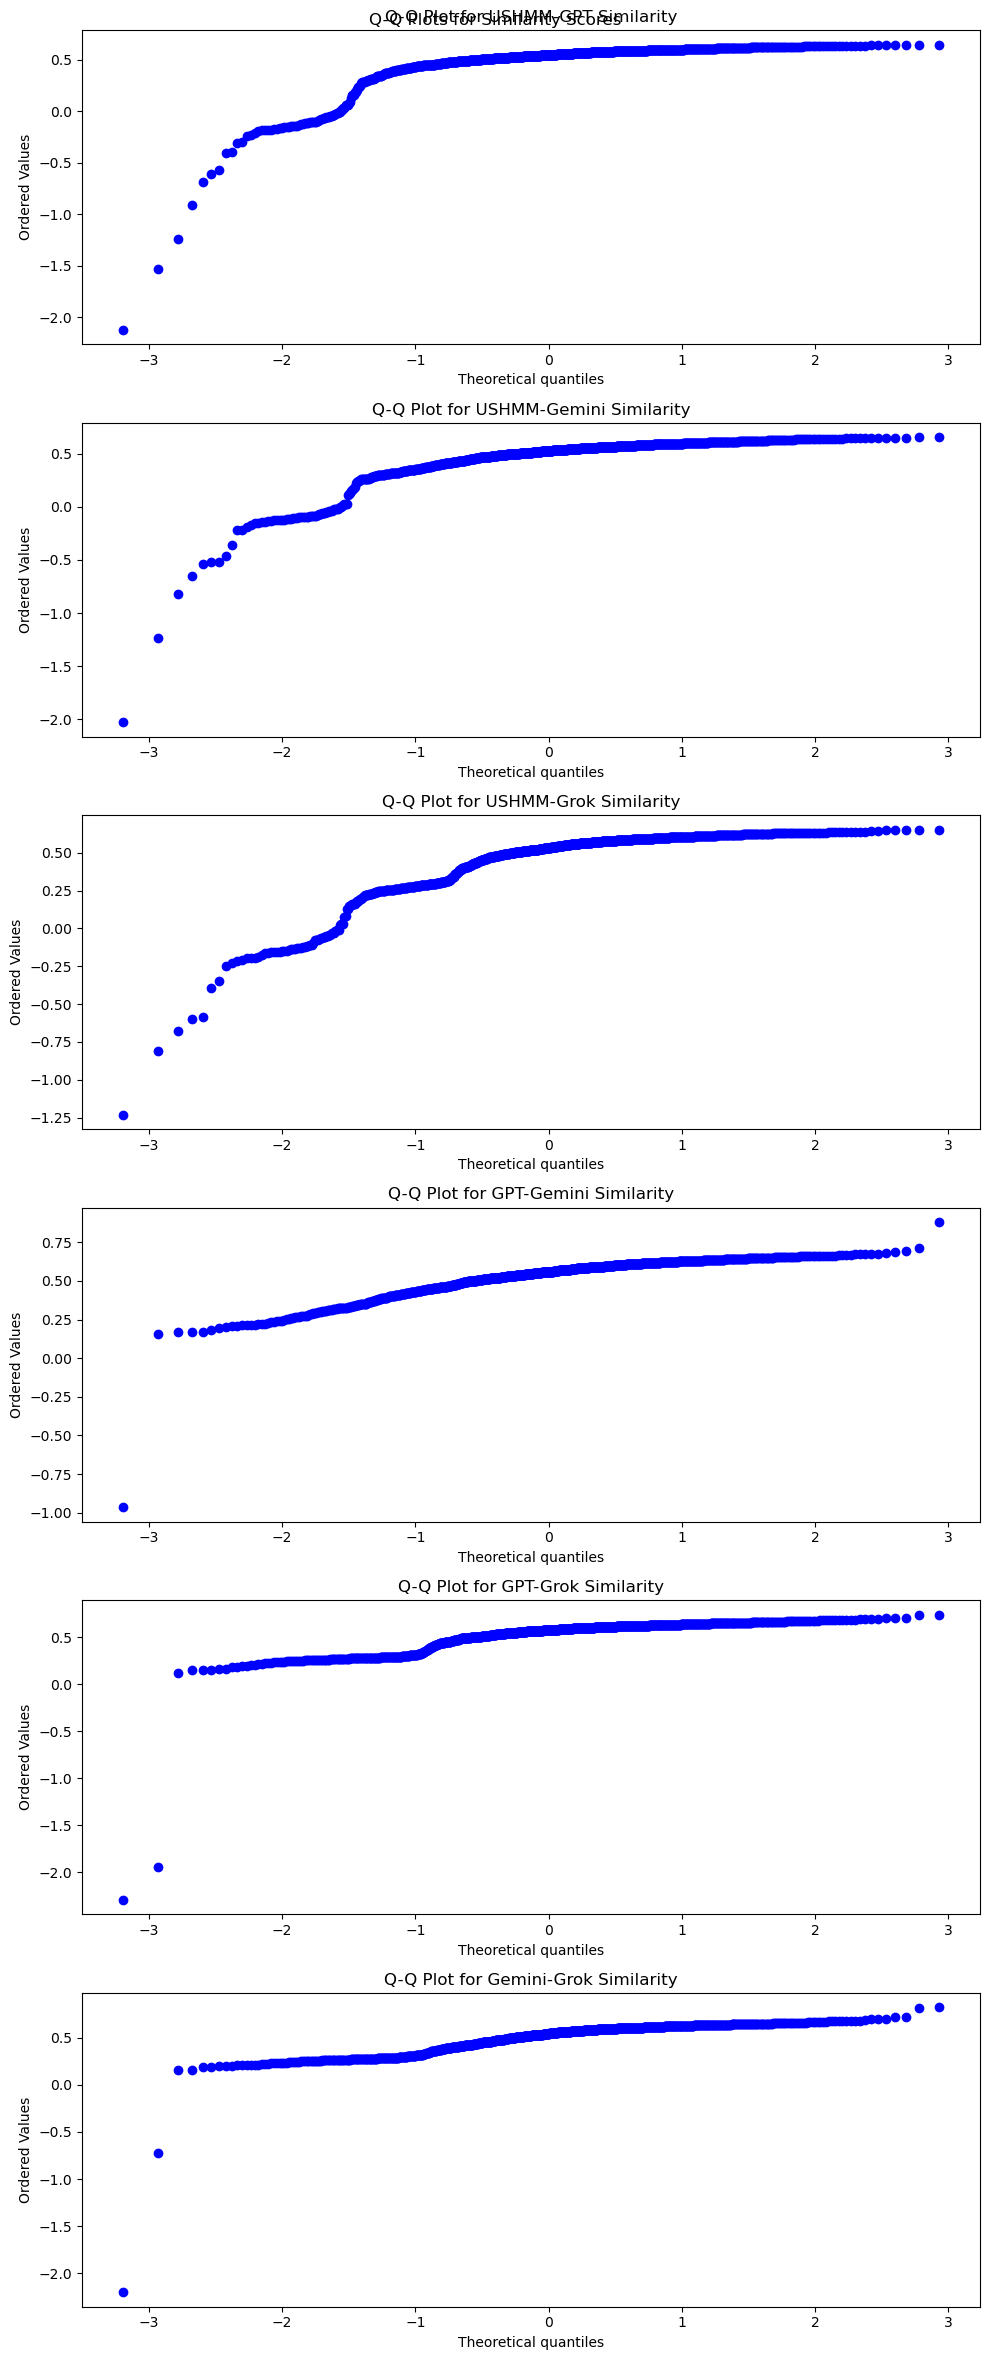

In [28]:
# Test for normality using Shapiro-Wilk test and QQ plots
print("\nShapiro-Wilk Test Results:")
print("H0: Data is normally distributed") 
print("H1: Data is not normally distributed")
print("\nResults for each similarity score:")

# Create figure for QQ plots
fig, axes = plt.subplots(len(similarity_cols), 1, figsize=(10, 4*len(similarity_cols)))
fig.suptitle('Q-Q Plots for Similarity Scores')

for i, col in enumerate(similarity_cols):
    # Shapiro-Wilk test
    stat, p_value = stats.shapiro(similarity_scores_df[col])
    print(f"\n{col}:")
    print(f"Statistic: {stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Normal distribution? {'Yes' if p_value > 0.05 else 'No'}")
    
    # QQ plot
    stats.probplot(similarity_scores_df[col], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot for {col}')

plt.tight_layout()
plt.show()


In [29]:
# Calculate Cohen's d between similarity columns
def cohens_d(x, y):
    n1, n2 = len(x), len(y)
    var1, var2 = np.var(x, ddof=1), np.var(y, ddof=1)
    
    # Pooled standard deviation
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # Cohen's d calculation
    d = (np.mean(x) - np.mean(y)) / pooled_se
    return d

# Get all pairs of similarity columns
similarity_pairs = []
similarity_cols = [col for col in similarity_scores_df.columns if 'Similarity' in col]

for i, col1 in enumerate(similarity_cols):
    for col2 in similarity_cols[i+1:]:
        d = cohens_d(similarity_scores_df[col1], similarity_scores_df[col2])
        similarity_pairs.append({
            'Comparison': f'{col1} vs {col2}',
            'Cohen\'s d': d,
            'Effect Size': 'Large' if abs(d) >= 0.8 else 'Medium' if abs(d) >= 0.5 else 'Small' if abs(d) >= 0.2 else 'Negligible'
        })

cohens_d_df = pd.DataFrame(similarity_pairs)
display(cohens_d_df)


,Comparison,Cohen's d,Effect Size
0,USHMM-GPT Similarity vs USHMM-Gemini Similarity,0.085641,Negligible
1,USHMM-GPT Similarity vs USHMM-Grok Similarity,0.126424,Negligible
2,USHMM-GPT Similarity vs GPT-Gemini Similarity,-0.275863,Small
3,USHMM-GPT Similarity vs GPT-Grok Similarity,-0.192904,Negligible
4,USHMM-GPT Similarity vs Gemini-Grok Similarity,-0.064858,Negligible
5,USHMM-Gemini Similarity vs USHMM-Grok Similarity,0.041565,Negligible
6,USHMM-Gemini Similarity vs GPT-Gemini Similarity,-0.397370,Small
7,USHMM-Gemini Similarity vs GPT-Grok Similarity,-0.294617,Small
8,USHMM-Gemini Similarity vs Gemini-Grok Similarity,-0.166056,Negligible
9,USHMM-Grok Similarity vs GPT-Gemini Similarity,-0.452064,Small


In [32]:
# Create scatter plot comparing lengths of responses
plt.figure(figsize=(10,8))
plt.scatter(
    similarity_scores_df['ushmm_article'].str.len(),
    similarity_scores_df['GPT_response'].str.len(), 
    alpha=0.5
)
plt.xlabel('USHMM Response Length (characters)')
plt.ylabel('GPT Response Length (characters)')
plt.title('Correlation between USHMM and GPT Response Lengths')

# Add correlation coefficient 
correlation = similarity_scores_df['USHMM_response'].str.len().corr(
    similarity_scores_df['GPT_response'].str.len()
)
plt.text(
    0.05, 0.95,
    f'Correlation: {correlation:.3f}',
    transform=plt.gca().transAxes
)

plt.tight_layout()
plt.show()


KeyError: 'ushmm_article'

<Figure size 1000x800 with 0 Axes>

Successfully loaded cleaned US queries data with LLM responses
Number of queries loaded: 776

First few rows:

Columns in dataset:

Column Headers:
- location
- Top queries
- ushmm_article
- GPT-4o Response
- Gemini Response
- Grok Response
- comments

Correlations between response lengths:
                          LLM Pair  Length Correlation
0    ushmm_article-GPT-4o Response           -0.010619
1    ushmm_article-Gemini Response           -0.026219
2      ushmm_article-Grok Response            0.006714
3  GPT-4o Response-Gemini Response            0.683515
4    GPT-4o Response-Grok Response            0.820975
5    Gemini Response-Grok Response            0.623938


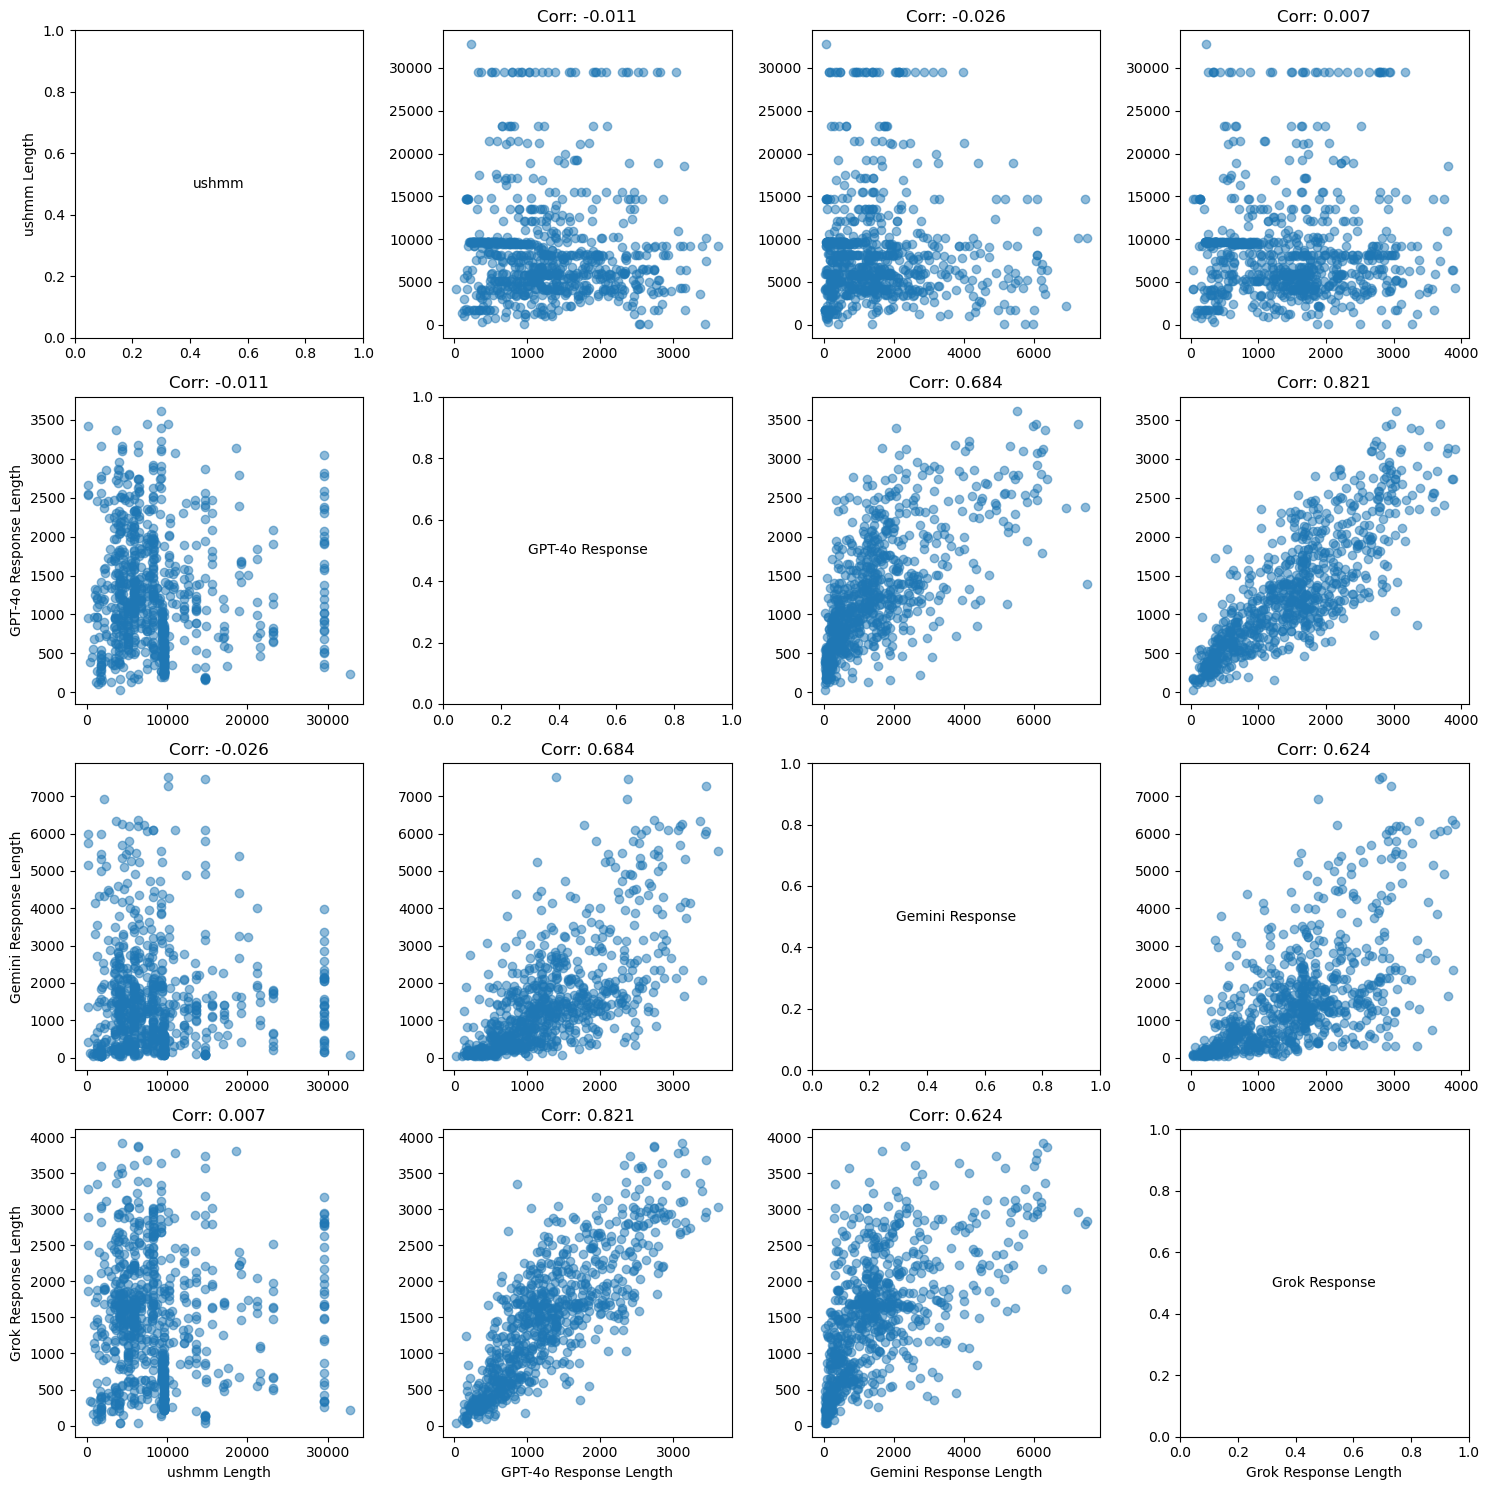

In [42]:
# Read in cleaned US queries data with LLM responses from Excel file
try:
    # Read the Excel file containing cleaned US queries and LLM responses
    us_queries_df = pd.read_excel('CLEANED US Queries with LLM Responses (No Composite Scores).xlsx')
    print("Successfully loaded cleaned US queries data with LLM responses")
    print(f"Number of queries loaded: {len(us_queries_df)}")
    print("\nFirst few rows:")
    #print(us_queries_df.head())
    print("\nColumns in dataset:")
    #print(us_queries_df.columns.tolist())
except FileNotFoundError:
    print("Error: Could not find 'CLEANED US Queries with LLM Responses (No Composite Scores).xlsx' file")
except Exception as e:
    print(f"Error loading data: {str(e)}")

# Print column headers to inspect data structure
print("\nColumn Headers:")
for col in us_queries_df.columns:
    print(f"- {col}")
# Calculate correlations between response lengths for all LLM pairs
length_correlations = pd.DataFrame(columns=['LLM Pair', 'Length Correlation'])

# Get length correlations between USHMM and each LLM
llm_pairs = [
    ('ushmm_article', 'GPT-4o Response'),
    ('ushmm_article', 'Gemini Response'), 
    ('ushmm_article', 'Grok Response'),
    ('GPT-4o Response', 'Gemini Response'),
    ('GPT-4o Response', 'Grok Response'),
    ('Gemini Response', 'Grok Response')
]
correlations = []
for llm1, llm2 in llm_pairs:
    corr = us_queries_df[f'{llm1}'].str.len().corr(
        us_queries_df[f'{llm2}'].str.len()
    )
    correlations.append({
        'LLM Pair': f'{llm1}-{llm2}',
        'Length Correlation': corr
    })
length_correlations = pd.DataFrame(correlations)
print("\nCorrelations between response lengths:")
print(length_correlations)

# Create scatter plot matrix comparing lengths
plt.figure(figsize=(15, 15))
llms = ['ushmm_article', 'GPT-4o Response', 'Gemini Response', 'Grok Response']
n = len(llms)

for i in range(n):
    for j in range(n):
        plt.subplot(n, n, i*n + j + 1)
        if i != j:
            plt.scatter(
                us_queries_df[llms[j]].str.len(),
                us_queries_df[llms[i]].str.len(),
                alpha=0.5
            )
            corr = us_queries_df[llms[j]].str.len().corr(
                us_queries_df[llms[i]].str.len()
            )
            plt.title(f'Corr: {corr:.3f}')
        else:
            plt.text(0.5, 0.5, llms[i].split('_')[0], ha='center', va='center')
        if i == n-1:
            plt.xlabel(f'{llms[j].split("_")[0]} Length')
        if j == 0:
            plt.ylabel(f'{llms[i].split("_")[0]} Length')

plt.tight_layout()
plt.show()


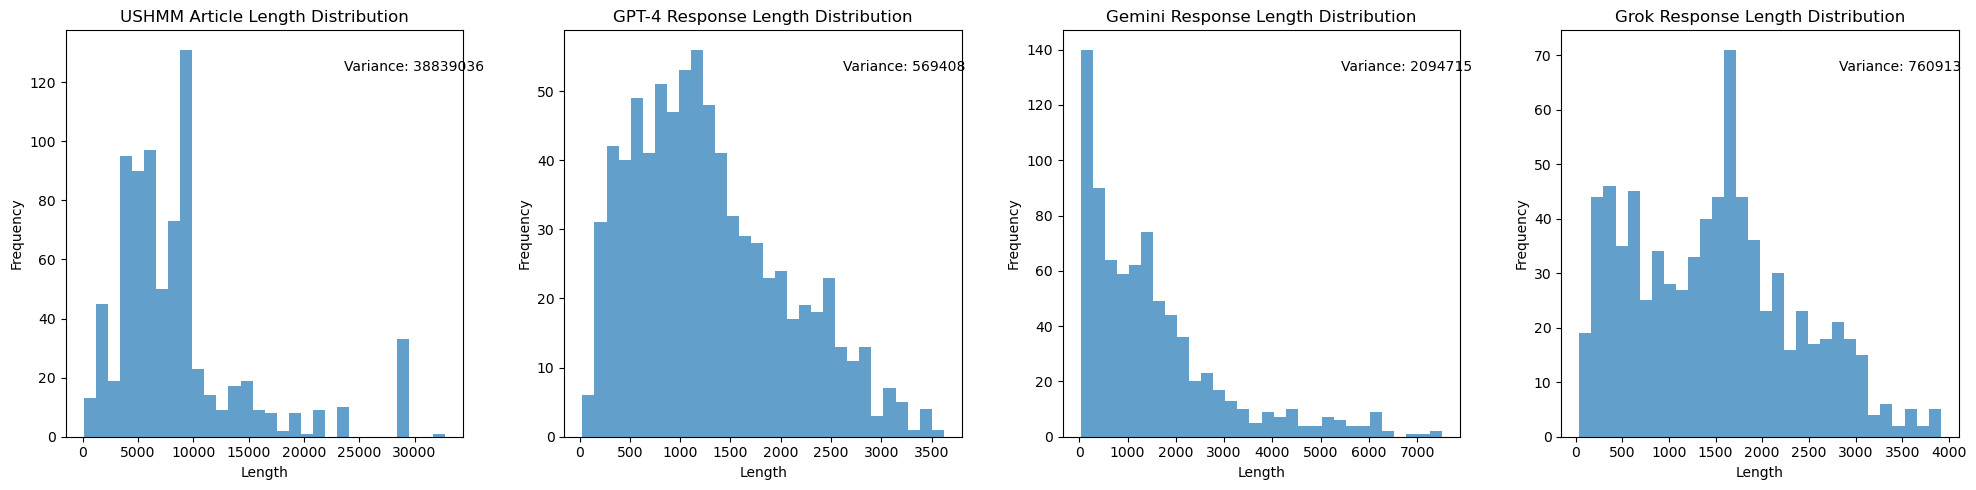


Response Length Summary Statistics:

USHMM Articles:
count      776.000000
mean      8619.565722
std       6232.097236
min        121.000000
25%       4511.000000
50%       7447.000000
75%       9615.000000
max      32767.000000
Name: ushmm_article, dtype: float64

GPT-4 Responses:
count     776.000000
mean     1293.480670
std       754.591299
min        29.000000
25%       708.500000
50%      1174.500000
75%      1768.750000
max      3620.000000
Name: GPT-4o Response, dtype: float64

Gemini Responses:
count     776.000000
mean     1521.744845
std      1447.312866
min        33.000000
25%       422.750000
50%      1200.000000
75%      2017.000000
max      7516.000000
Name: Gemini Response, dtype: float64

Grok Responses:
count     776.000000
mean     1481.458763
std       872.303345
min        40.000000
25%       723.250000
50%      1489.000000
75%      2043.750000
max      3912.000000
Name: Grok Response, dtype: float64


In [43]:
# Create distribution plots for response lengths
plt.figure(figsize=(20, 5))

# Histogram for USHMM article lengths
plt.subplot(1,4,1)
plt.hist(us_queries_df['ushmm_article'].str.len(), bins=30, alpha=0.7)
plt.title('USHMM Article Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
var_ushmm = us_queries_df['ushmm_article'].str.len().var()
plt.text(0.7, 0.9, f'Variance: {var_ushmm:.0f}', 
         transform=plt.gca().transAxes)

# Histogram for GPT-4 response lengths  
plt.subplot(1,4,2)
plt.hist(us_queries_df['GPT-4o Response'].str.len(), bins=30, alpha=0.7)
plt.title('GPT-4 Response Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
var_gpt = us_queries_df['GPT-4o Response'].str.len().var()
plt.text(0.7, 0.9, f'Variance: {var_gpt:.0f}',
         transform=plt.gca().transAxes)

# Histogram for Gemini response lengths
plt.subplot(1,4,3) 
plt.hist(us_queries_df['Gemini Response'].str.len(), bins=30, alpha=0.7)
plt.title('Gemini Response Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
var_gemini = us_queries_df['Gemini Response'].str.len().var()
plt.text(0.7, 0.9, f'Variance: {var_gemini:.0f}',
         transform=plt.gca().transAxes)

# Histogram for Grok response lengths
plt.subplot(1,4,4)
plt.hist(us_queries_df['Grok Response'].str.len(), bins=30, alpha=0.7) 
plt.title('Grok Response Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
var_grok = us_queries_df['Grok Response'].str.len().var()
plt.text(0.7, 0.9, f'Variance: {var_grok:.0f}',
         transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nResponse Length Summary Statistics:")
print("\nUSHMM Articles:")
print(us_queries_df['ushmm_article'].str.len().describe())
print("\nGPT-4 Responses:")
print(us_queries_df['GPT-4o Response'].str.len().describe())
print("\nGemini Responses:") 
print(us_queries_df['Gemini Response'].str.len().describe())
print("\nGrok Responses:")
print(us_queries_df['Grok Response'].str.len().describe())

